# **Clasificación de Radiografías Musculoesqueléticas (MURA)**

Este proyecto tiene como objetivo desarrollar un modelo de **clasificación binaria** capaz de identificar si una radiografía musculoesquelética (perteneciente al conjunto de datos [MURA](https://stanfordmlgroup.github.io/competitions/mura/)) presenta una **anomalía (abnormal)** o es **normal (negative)**.

---

## ¿Qué haremos?

1. **Prepararemos los datos** a partir de las imágenes del dataset MURA.
2. **Crearemos un modelo basado en ResNet18 preentrenado**, adaptado para clasificación binaria.
3. **Entrenaremos** el modelo sobre las radiografías con técnicas de fine-tuning.
4. **Evaluaremos su rendimiento** con métricas como F1-score, accuracy y matriz de confusión.
5. **Visualizaremos predicciones correctas y errores** para interpretar el comportamiento.
6. **Guardaremos el modelo final** para uso futuro.

## **Paso 1: Importaciones y librerías necesarias**

A continuación, cargamos todas las librerías necesarias para procesamiento de imágenes, modelado con PyTorch, visualización y evaluación.

In [1]:
# Librerías de procesamiento y visualización
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
import random

# PyTorch y herramientas para modelado
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from PIL import Image

# Métricas
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn as sns

# Guardado de modelo
import joblib

##  **Paso 2: Configuración e Hiperparámetros**

En este bloque definimos los valores clave para entrenar nuestro modelo:
- Ruta del dataset MURA completo (guardado en local debido al peso)
- Tamaño de imagen y lote
- Número de épocas
- Learning rate
- Patiencia para early stopping y reducción de LR

In [2]:
# Ruta al dataset MURA completo
DATASET_DIR = "/Users/alvarosanchez/Downloads/MURA-v1.1"
train_dir = os.path.join(DATASET_DIR, "train")
valid_dir = os.path.join(DATASET_DIR, "valid")

# Dispositivo (GPU si está disponible)
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print("Computando en:", DEVICE)

# Tamaño de imagen
IMAGE_SIZE = (224, 224)

# Hiperparámetros
BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4
EARLYSTOP_PATIENCE = 5
LR_PATIENCE = 5
WEIGHT_DECAY = 1e-4  # Regularización L2 para evitar overfitting

# Ruta donde se guardará el modelo final
MODEL_PATH = "/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/ML_Clasificacion_Radiografias_Muscoesqueleticas/src/models/resnet18_final_model.pkl"

Computando en: mps


## **Paso 3: Transformaciones, creación del Dataset y DataLoaders**

Para entrenar un modelo robusto, es crucial preparar adecuadamente los datos. En este paso:

- Aplicaremos **transformaciones de aumento de datos (data augmentation)** al conjunto de entrenamiento para mejorar la capacidad de generalización del modelo.
- Estandarizaremos todas las imágenes al mismo tamaño (`224x224`) y normalizaremos con la media y desviación estándar de ImageNet (ya que la ResNet fue preentrenada con este dataset).
- Crearemos los `DataLoader` de entrenamiento y validación para facilitar la iteración por lotes durante el entrenamiento.

Además, incluimos un pequeño análisis para detectar posibles problemas de estructura de carpetas o archivos ocultos.

In [3]:
# Transformaciones para entrenamiento y validación
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  # Normalización de ImageNet
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset personalizado corregido para evitar errores con archivos ocultos como .DS_Store
class MURABinaryDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        root_dir = Path(root_dir)

        for body_part in root_dir.iterdir():
            if not body_part.is_dir() or body_part.name.startswith('.'):
                continue
            for patient_dir in body_part.iterdir():
                if not patient_dir.is_dir():
                    continue
                for study_dir in patient_dir.iterdir():
                    if not study_dir.is_dir():
                        continue
                    label = 1 if "positive" in study_dir.name else 0
                    for img_path in study_dir.glob("*.png"):
                        self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Crear datasets con rutas corregidas
train_dataset = MURABinaryDataset(train_dir, transform=transform_train)
valid_dataset = MURABinaryDataset(valid_dir, transform=transform_val)

# Crear dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Dataset cargado: {len(train_dataset)} entrenamiento, {len(valid_dataset)} validación")

Dataset cargado: 36808 entrenamiento, 3197 validación


## **Paso 4: Análisis del desequilibrio de clases**

Antes de entrenar el modelo, es crucial analizar la distribución de las clases en el conjunto de entrenamiento.  
En este problema, queremos clasificar radiografías como **normales (0)** o **anormales (1)**.  
Si hay una diferencia significativa entre el número de imágenes por clase, el modelo podría sesgarse hacia la clase mayoritaria.

En este paso:

- Calcularemos cuántas imágenes hay de cada clase.
- Visualizaremos esa distribución.
- Calcularemos **pesos inversamente proporcionales** al número de muestras por clase para equilibrar la función de pérdida (`CrossEntropyLoss`), de forma que el modelo aprenda sin favorecer la clase dominante.

Distribución de clases en el conjunto de entrenamiento:
Clase 0 (Normal (0)): 21935 ejemplos
Clase 1 (Abnormal (1)): 14873 ejemplos


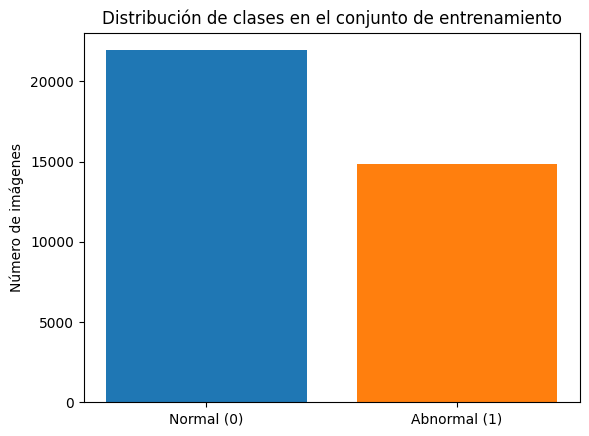


Pesos calculados para la función de pérdida: [1.6780487804878048, 2.4748201438848922]


In [4]:
from collections import Counter
import matplotlib.pyplot as plt

# Contar la cantidad de ejemplos por clase en el set de entrenamiento
labels = [label for _, label in train_dataset]
label_counts = Counter(labels)

print("Distribución de clases en el conjunto de entrenamiento:")
for clase, cantidad in label_counts.items():
    etiqueta = "Normal (0)" if clase == 0 else "Abnormal (1)"
    print(f"Clase {clase} ({etiqueta}): {cantidad} ejemplos")

# Visualización de la distribución de clases
plt.bar(['Normal (0)', 'Abnormal (1)'], [label_counts[0], label_counts[1]], color=['#1f77b4', '#ff7f0e'])
plt.title("Distribución de clases en el conjunto de entrenamiento")
plt.ylabel("Número de imágenes")
plt.show()

# Cálculo de pesos inversamente proporcionales a la frecuencia de las clases
total = sum(label_counts.values())
class_weights = [total / label_counts[0], total / label_counts[1]]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

print(f"\nPesos calculados para la función de pérdida: {class_weights}")

## **Paso 5: Definición del modelo ResNet18 y descongelado parcial**

En este paso, se define el modelo de aprendizaje profundo basado en **ResNet18**, una red convolucional preentrenada en **ImageNet**.

Como estrategia de optimización, **descongelamos parcialmente** las capas desde `layer2` en adelante (`layer2`, `layer3`, `layer4` y `fc`).  
Esto permite que el modelo ajuste sus pesos en capas más profundas para aprender patrones más específicos del dominio de rayos X musculoesqueléticos, manteniendo congeladas las primeras capas que capturan patrones visuales más generales.

Además, se modifica la **capa final (`fc`)** del modelo para realizar **clasificación binaria**, distinguiendo entre radiografías **normales (0)** y **anormales (1)**.

In [5]:
# Cargar la ResNet18 preentrenada en ImageNet
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Descongelamos las capas desde layer2 en adelante (layer2, layer3, layer4, fc)
# Esto permite que el modelo ajuste pesos en capas más profundas para aprender mejor patrones específicos del dataset MURA
for name, param in resnet18.named_parameters():
    if name.startswith('layer2') or name.startswith('layer3') or name.startswith('layer4') or name.startswith('fc'):
        param.requires_grad = True  # Se entrena
    else:
        param.requires_grad = False  # Se congela

# Reemplazar la capa final (fc) para clasificación binaria
# Originalmente está diseñada para 1000 clases de ImageNet
num_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_features, 2)  # 2 clases: normal (0) y abnormal (1)

# Enviar modelo al dispositivo
resnet18 = resnet18.to(DEVICE)

# Ver estructura final del modelo (opcional)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## **Paso 6: Configuración del entrenamiento**

En este paso se define todo lo necesario para el entrenamiento del modelo:

- La **función de pérdida** (`CrossEntropyLoss`) adaptada al posible desbalance de clases usando pesos.
- El **optimizador** (`Adam`) que actualizará los pesos del modelo.
- Un **scheduler** (`ReduceLROnPlateau`) que reduce automáticamente la tasa de aprendizaje si el modelo deja de mejorar en validación.
- Parámetros de **early stopping** que interrumpen el entrenamiento si el modelo no mejora después de varios *epochs* consecutivos.

Esta configuración permite un entrenamiento más estable, eficiente y adaptado a las características del conjunto de datos.

In [6]:
from sklearn.utils.class_weight import compute_class_weight

# Obtener pesos de clase para abordar el desbalance (0: negativo, 1: positivo)
class_counts = [label for _, label in train_dataset]
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_counts), y=class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

# Definir la función de pérdida con pesos de clase
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizador: Adam
optimizer = optim.Adam(resnet18.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Scheduler que reduce el learning rate si la validación no mejora
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,           # Reducir LR a la mitad
    patience=LR_PATIENCE, # Número de epochs sin mejora para reducir LR
    verbose=True
)

# Inicializamos variables para early stopping
best_val_loss = float('inf')
epochs_no_improve = 0

/opt/homebrew/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### **Paso 7: Entrenamiento del modelo**

En este paso se entrena el modelo ResNet18 con las configuraciones previamente definidas.  
Se aplicará Early Stopping para evitar overfitting si la pérdida de validación no mejora durante `EARLYSTOP_PATIENCE` épocas.  
También se monitorizan métricas clave como la `accuracy`, el `F1-score`, y la pérdida (`loss`) tanto en entrenamiento como en validación.

Además, si se alcanza una mejor puntuación en validación, el modelo se guarda automáticamente.

In [7]:
print("Comienza el entrenamiento...")

for epoch in range(NUM_EPOCHS):
    resnet18.train()  # Ponemos el modelo en modo entrenamiento
    train_loss = 0.0
    y_true, y_pred = [], []

    # Bucle sobre los batches del set de entrenamiento
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()  # Reseteamos los gradientes del optimizador
        outputs = resnet18(images)  # Hacemos predicciones con el modelo
        loss = criterion(outputs, labels)  # Calculamos la pérdida respecto a las etiquetas reales
        loss.backward()  # Calculamos los gradientes (backpropagation)
        optimizer.step()  # Actualizamos los pesos

        train_loss += loss.item() * images.size(0)  # Acumulamos pérdida total del batch

        _, preds = torch.max(outputs, 1)  # Obtenemos las clases predichas (mayor probabilidad)
        y_true.extend(labels.cpu().numpy())  # Guardamos etiquetas reales
        y_pred.extend(preds.cpu().numpy())   # Guardamos predicciones

    avg_train_loss = train_loss / len(train_loader.dataset)  # Pérdida media del entrenamiento

    # Validación (sin actualización de pesos)
    resnet18.eval()  # Ponemos el modelo en modo evaluación
    val_loss = 0.0
    val_true, val_pred = [], []

    with torch.no_grad():  # No calculamos gradientes (más rápido y eficiente)
        for images, labels in valid_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = resnet18(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            val_true.extend(labels.cpu().numpy())
            val_pred.extend(preds.cpu().numpy())

    avg_val_loss = val_loss / len(valid_loader.dataset)  # Pérdida media de validación
    scheduler.step(avg_val_loss)  # Actualizamos el LR si la validación no mejora

    # Cálculo de métricas de validación
    acc = accuracy_score(val_true, val_pred)  # Exactitud
    f1 = f1_score(val_true, val_pred, average="binary")  # F1 para clasificación binaria

    # Imprimimos resultados de la época actual
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Acc: {acc:.4f} | F1: {f1:.4f}")

    # Guardado del mejor modelo (con menor val_loss)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(resnet18.state_dict(), MODEL_PATH)  # Guardamos el modelo
        print("Mejor modelo guardado.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= EARLYSTOP_PATIENCE:  # Si no mejora durante N epochs, paramos
            print("Early stopping activado.")
            break

Comienza el entrenamiento...
Epoch 1 | Train Loss: 0.5380 | Val Loss: 0.5063 | Acc: 0.7707 | F1: 0.7402
Mejor modelo guardado.
Epoch 2 | Train Loss: 0.4766 | Val Loss: 0.4890 | Acc: 0.7842 | F1: 0.7607
Mejor modelo guardado.
Epoch 3 | Train Loss: 0.4514 | Val Loss: 0.4864 | Acc: 0.7798 | F1: 0.7626
Mejor modelo guardado.
Epoch 4 | Train Loss: 0.4345 | Val Loss: 0.4843 | Acc: 0.7973 | F1: 0.7700
Mejor modelo guardado.
Epoch 5 | Train Loss: 0.4177 | Val Loss: 0.4517 | Acc: 0.8058 | F1: 0.7817
Mejor modelo guardado.
Epoch 6 | Train Loss: 0.3997 | Val Loss: 0.4830 | Acc: 0.8114 | F1: 0.7901
Epoch 7 | Train Loss: 0.3833 | Val Loss: 0.4475 | Acc: 0.7942 | F1: 0.7833
Mejor modelo guardado.
Epoch 8 | Train Loss: 0.3682 | Val Loss: 0.5143 | Acc: 0.7936 | F1: 0.7645
Epoch 9 | Train Loss: 0.3503 | Val Loss: 0.4877 | Acc: 0.7954 | F1: 0.7786
Epoch 10 | Train Loss: 0.3288 | Val Loss: 0.4715 | Acc: 0.8148 | F1: 0.7956
Epoch 11 | Train Loss: 0.3128 | Val Loss: 0.4992 | Acc: 0.7970 | F1: 0.7824
Epoch 

A pesar de alcanzar una precisión máxima del 81.48% y un F1-score de 0.7901, el modelo no ha superado significativamente al mejor resultado anterior con descongelado desde layer3, donde se alcanzó un F1 cercano al 0.814.

## **Paso 8: Evaluación del modelo final**

En esta sección vamos a:
- Cargar el mejor modelo guardado durante el entrenamiento.
- Evaluarlo sobre el conjunto de validación.
- Generar el reporte de clasificación (precision, recall, F1-score, etc).
- Visualizar la matriz de confusión.


Classification Report:
              precision    recall  f1-score   support

    negative       0.80      0.81      0.80      1667
    positive       0.79      0.78      0.78      1530

    accuracy                           0.79      3197
   macro avg       0.79      0.79      0.79      3197
weighted avg       0.79      0.79      0.79      3197



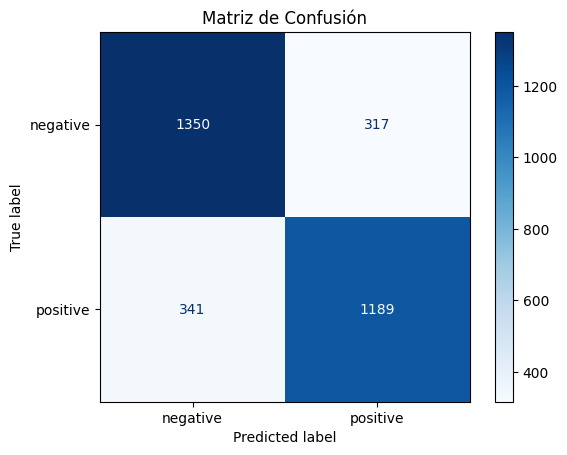

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Cargar el mejor modelo guardado durante el entrenamiento
resnet18.load_state_dict(torch.load(MODEL_PATH))
resnet18.eval()  # Importante: modo evaluación desactiva dropout, batchnorm dinámica, etc.

# Evaluamos sobre el conjunto de validación
all_preds = []
all_labels = []

with torch.no_grad():  # No necesitamos gradientes en esta fase
    for images, labels in valid_loader:
        images = images.to(DEVICE)
        outputs = resnet18(images)
        _, preds = torch.max(outputs, 1)  # Elegimos la clase con mayor probabilidad

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Reporte de métricas
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["negative", "positive"]))

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "positive"])
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión")
plt.show()

## **Paso 9: Guardado del modelo final**

Una vez que hemos evaluado el modelo y verificado su rendimiento, es hora de guardar sus pesos entrenados para su reutilización en producción o inferencia posterior.

El archivo se almacenará en la carpeta de modelos del proyecto. ("/src/models")

In [9]:
import joblib
import os

# Ruta final donde se guardará el modelo entrenado
final_model_path = "/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/ML_Clasificacion_Radiografias_Muscoesqueleticas/src/models/resnet18_final_model.joblib"

# Guardamos únicamente los pesos del modelo (state_dict)
# Joblib guarda objetos binarios, útil para modelos en producción
joblib.dump(resnet18.state_dict(), final_model_path)

print(f"Modelo guardado correctamente en: {final_model_path}")

Modelo guardado correctamente en: /Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/ML_Clasificacion_Radiografias_Muscoesqueleticas/src/models/resnet18_final_model.joblib
